In [1]:
from scipy.signal import freqz, dbode

import matplotlib.pyplot as plt

import numpy as np
from numpy.polynomial.polynomial import polyval

In [2]:
from scipy.signal import butter, dlti

rb2 = 0.2
b2 = dlti(*butter(2, rb2, fs=1.0), dt=1.0)
wb2, magb2, phaseb2 = dbode(b2)
fb2 = wb2 / (2.0 * np.pi)

In [3]:
def freqresp_fir(taps, f_norm):
    """Frequency response of an FIR filter is easy"""
    w = f_norm * 2.0 * np.pi  # [rad]/samplerate
    z = np.exp(-1j * w)
    h = polyval(z, taps, tensor=False)

    mag = 20 * np.log10(np.abs(h))  # Magnitude of complex response vector
    phase = np.rad2deg(np.unwrap(np.angle(h), period=3.14))  # Angle of complex response vector

    return mag, phase # normalized to samplerate

In [ ]:
def freqresp_iir(statespace):
    """
    NOT TESTED YET

    Frequency response of a SISO IIR filter in canonical form is slightly more involved
    than for IIR filters.
    
    To avoid allocations and matrix inverse, we can start with the canonical form and
    convert to transfer function:
    https://en.wikipedia.org/wiki/State-space_representation#Canonical_realizations
    https://github.com/scipy/scipy/blob/main/scipy/signal/_lti_conversion.py#L196

    Then take the frequency response the usual way:
    https://github.com/scipy/scipy/blob/main/scipy/signal/_filter_design.py#L482

    Nonzero D value comes from a system that is not "strictly proper"
    but can be added to the total transfer function as a constant
    so that the whole transfer function is (a / b) + d instead of just (a / b)
    https://en.wikipedia.org/wiki/State-space_representation#Proper_transfer_functions
    """
    # Unpack nontrivial values of canonical statespace repr
    avec = statespace.A[0, :]
    cvec = statespace.C[0, :]

    d = statespace.D[0][0]

    # Build transfer function polynomial coeffs
    atf = cvec
    btf = np.array([x for x in -avec] + [1.0])

    return atf, btf, d



    

Text(0.5, 0.98, 'Response')

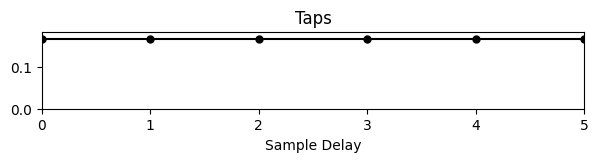

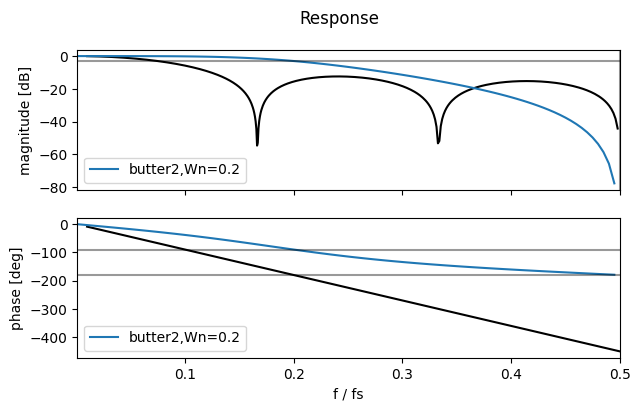

In [5]:
# Make taps
n = 6
tn = np.linspace(1, n, n)
tmid = np.mean(tn)
v = tn - tmid
# b = np.exp(v ** -2)
# b = np.sinc(v)
b= np.ones(n)
b /= sum(b)  # DC gain = 1

# Get frequency response
# 0.01 - 0.49 fraction of samplerate
# w, h = freqz(b)
# w, mag, phase = dbode((b, 1, 1))
nw = 1000
f = np.logspace(-2, np.log10(0.499999), nw)  # f/fs normalized samplerate
mag, phase = freqresp_fir(b, f)

# Clip nans
mag[np.where(mag<-100)] = np.nan
gt1 = np.where(mag > 0.0)

# Taps
plt.figure(figsize=(7,1))
plt.plot(tn-1, b, marker='.', markersize=10, color='k')
plt.ylim(min(min(b), 0.0), max(b) * 1.1)
plt.xlim(0.0, n-1)
plt.xlabel("Sample Delay")
plt.title("Taps")

# Mag
fig, (ax1, ax2) = plt.subplots(2,1, figsize=((7,4)), sharex=True)
ax1.plot(f, mag, color='k')
ax1.plot(fb2, magb2, label=f"butter2,Wn={rb2}")
if np.array(gt1).size > 0:
    ax1.scatter(f[gt1], mag[gt1], marker='o', alpha=0.4, color='red', label="G>1")
ax1.set_ylabel("magnitude [dB]")
ax1.set_xlim(1e-3, 0.5)
ax1.axvline(0.5, color='k', alpha=0.4)
ax1.axhline(-3, color='k', alpha=0.4)
ax1.legend()

# Phase
ax2.plot(f, phase, color='k')
ax2.plot(fb2, phaseb2, label=f"butter2,Wn={rb2}")
ax2.set_ylabel("phase [deg]")
ax2.set_xlabel("f / fs")
ax2.axhline(-90, color='k', alpha=0.4)
ax2.axhline(-180, color='k', alpha=0.4)
ax2.legend()
plt.suptitle("Response")